In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_rows',None)

In [312]:
data = pd.read_csv('./../../../communal/Ames_Housing_Price_Data_cleaned_2.csv')

In [313]:
data[['TotalBsmtSF','BsmtFinSF1','SalePrice']].corr()

,TotalBsmtSF,BsmtFinSF1,SalePrice
TotalBsmtSF,1.000000,0.516684,0.659358
BsmtFinSF1,0.516684,1.000000,0.465323
SalePrice,0.659358,0.465323,1.000000


In [314]:
data = data.drop(['PID','Prop_Addr','mean_LotFrontage'],axis = 1)
predict = data['SalePrice']
log_predict = np.log(predict)
data.drop(['SalePrice','lot_bucket','lat','long'],axis = 1, inplace = True)
dummy = pd.get_dummies(data,drop_first = True)

In [315]:
data.head()

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,64.9,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal
2,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal
3,1001,30,C (all),60.0,6060,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,11,2007,WD,Normal
4,1039,70,RL,80.0,8146,Pave,None,Reg,Lvl,AllPub,...,111,0,None,None,None,0,5,2009,WD,Normal


In [316]:
dummy.head()

,GrLivArea,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,856,30,64.9,7890,6,6,1939,1950,0.0,238.0,...,0,0,0,0,1,0,0,0,1,0
1,1049,120,42.0,4235,5,5,1984,1984,149.0,552.0,...,0,0,0,0,1,0,0,0,1,0
2,1049,120,42.0,4235,5,5,1984,1984,149.0,552.0,...,0,0,0,0,1,0,0,0,1,0
3,1001,30,60.0,6060,5,9,1930,2007,0.0,737.0,...,0,0,0,0,1,0,0,0,1,0
4,1039,70,80.0,8146,4,8,1900,2003,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0


# Creating a Model  with all variables

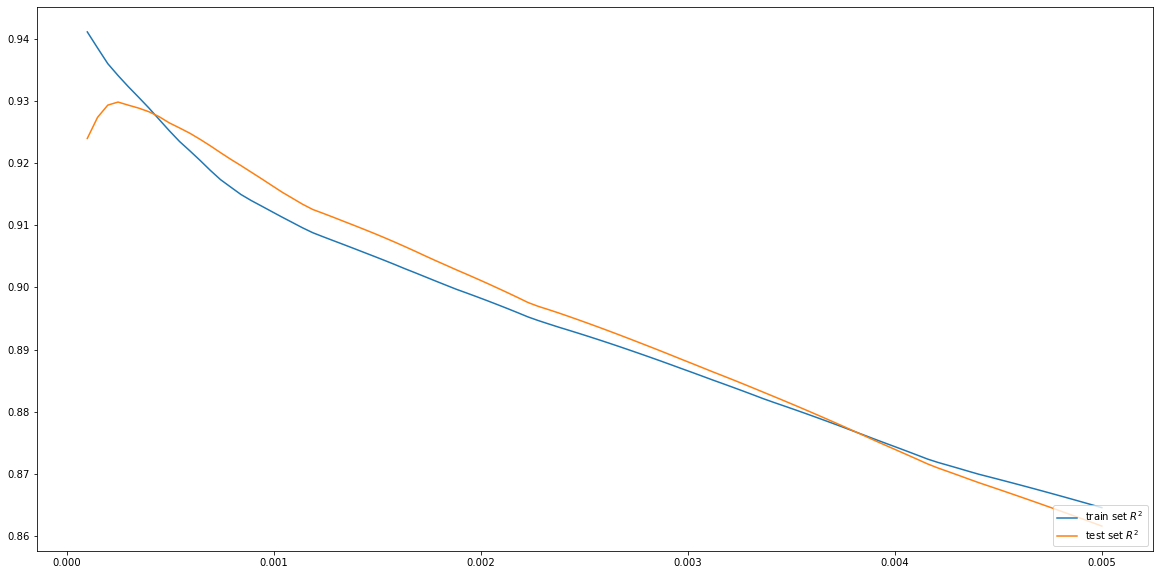

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X_train, X_test, y_train, y_test = train_test_split(dummy,log_predict,test_size=.33)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
lasso = Lasso()


    
alphas = np.linspace(1e-4,.005,100)
coefs = []
train_R2 = []
test_R2  = []
for i,alpha in enumerate(alphas):
    print(i, end = '\r')
    lasso.set_params(alpha = alpha, max_iter = 50000)
    lasso.fit(X_train_scaled,y_train)
    coefs.append(lasso.coef_)
    train_R2.append(lasso.score(X_train_scaled,y_train))
    test_R2.append(lasso.score(scaler.transform(X_test),y_test))
    
plt.plot(alphas, train_R2, label=r'train set $R^2$')
plt.plot(alphas, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)


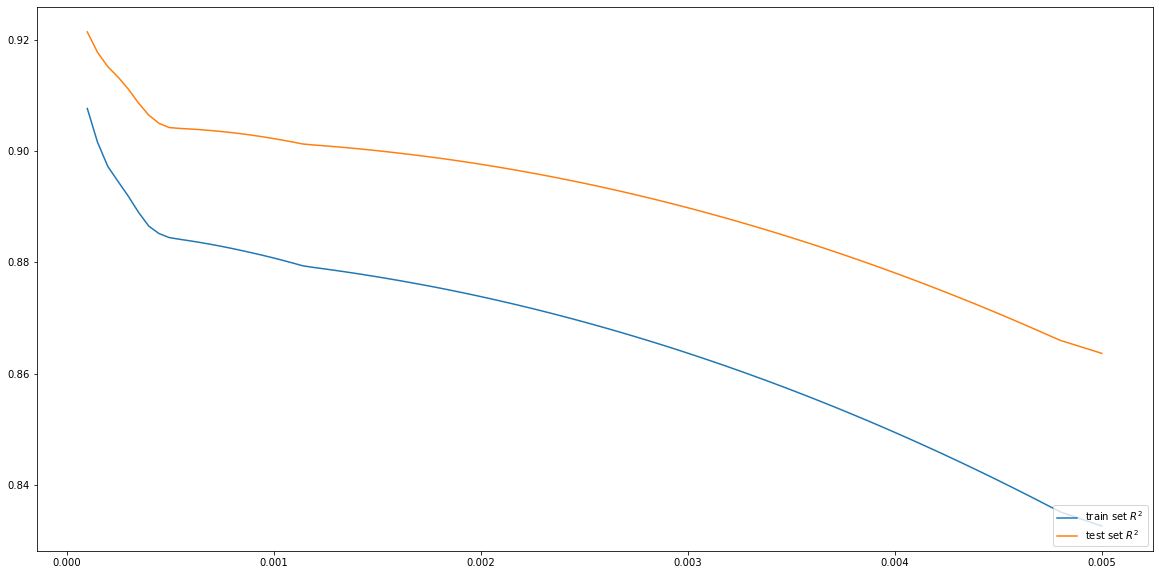

In [6]:
d = pd.get_dummies(data, drop_first=True)
with open("play.txt", "w") as file1:
    coefs = []
    train_R2 = []
    test_R2  = []
    
    alphas = np.linspace(1e-4,.005,100)
    for alpha in alphas:
        lasso.set_params(alpha = alpha, max_iter = 20000)
        lasso.fit(X_train,np.log(y_train))
        coefs.append(lasso.coef_)
        train_R2.append(lasso.score(X_train,np.log(y_train)))
        test_R2.append(lasso.score(X_test,np.log(y_test)))
        print(alpha, end = '\r')

    coefs_data = pd.DataFrame(np.array(coefs),columns = d.columns)
    vals = pd.Series(coefs[50], index = d.columns)
    k_heaviest_weights = vals.abs().sort_values(ascending = False).index[:15]
    plt.rcParams["figure.figsize"] = (20,10)
    for name in k_heaviest_weights:
        plt.plot(alphas, coefs_data[name], label=name)
    plt.legend(loc=1)    
    plt.title(f'Change of Lasso Slopes Varying Alpha for ALL NEIGHBORHOODS , num_observations = {len(d)}')
    plt.savefig(f'neighborhoodLasso/ALL_HOODS.pdf')
    plt.clf()
    
    plt.plot(alphas, train_R2, label=r'train set $R^2$')
    plt.plot(alphas, test_R2, label=r'test set $R^2$')
    plt.legend(loc=4)
    plt.savefig('TEST')

# Training models for each neighborhood to see what features are important to what neighborhood (If any difference even exists)

In [21]:
lasso = Lasso()
scaler = MinMaxScaler()
max_iter = 200000


with open("play2.txt", "w") as file:

    #For each neighborhood
    for i,neighborhood in enumerate(data.Neighborhood.unique()[:27]):
        print(i, end = '\r')
        indices = data[data.Neighborhood == neighborhood].index
        coefs = []
        alphas = np.linspace(1e-4,.005,250)
        for alpha in alphas:
            lasso.set_params(alpha = alpha, max_iter = max_iter)
            lasso.fit(scaler.fit_transform(dummy.iloc[indices]), log_predict[indices])
            coefs.append(lasso.coef_)
            

        coefs_data = pd.DataFrame(np.array(coefs),columns = d.columns)
        vals = pd.Series(coefs[99], index = d.columns)
        k_heaviest_weights = vals.abs().sort_values(ascending = False).index[:15]
        plt.rcParams["figure.figsize"] = (20,10)
        for name in k_heaviest_weights:
            plt.plot(alphas, coefs_data[name], label=name)
        plt.legend(loc=1)    
        plt.title(f'Change of Lasso Slopes Varying Alpha for {neighborhood} , num_observations = {len(indices)}')
        plt.savefig(f'neighborhoodLasso/{neighborhood}2.pdf')
        plt.clf()
        
        file.writelines(f'********** {neighborhood}  {len(indices)} observations **********\n')
        file.writelines(vals[k_heaviest_weights].to_string())
        file.writelines('\n\n\n\n')
        
  

    #For whole dataset
    coefs = []
    alphas = np.linspace(1e-4,.005,250)
    for alpha in alphas:
        lasso.set_params(alpha = alpha, max_iter = max_iter)
        lasso.fit(scaler.fit_transform(dummy), log_predict)
        coefs.append(lasso.coef_)


    coefs_data = pd.DataFrame(np.array(coefs),columns = d.columns)
    vals = pd.Series(coefs[99], index = d.columns)
    k_heaviest_weights = vals.abs().sort_values(ascending = False).index[:50]
    plt.rcParams["figure.figsize"] = (20,10)
    for name in k_heaviest_weights:
        plt.plot(alphas, coefs_data[name], label=name)
    plt.legend(loc=1)    
    plt.title(f'Change of Lasso Slopes Varying Alpha for ALL DATA , num_observations = {len(dummy)}')
    plt.savefig(f'neighborhoodLasso/ALLHOODS2.pdf')
    plt.clf()

    file.writelines(f'********** ALL DATA  {len(dummy)} observations **********\n')
    file.writelines(vals[k_heaviest_weights].to_string())
    file.writelines('\n\n\n\n')

#         plt.plot(alphas, train_R2, label=r'train set $R^2$')
#         plt.plot(alphas, test_R2, label=r'test set $R^2$')
#         plt.legend(loc=4)
#         plt.savefig('TEST')



print('DONE')     
    

<Figure size 1440x720 with 0 Axes>

# Looking at the Multi Collinearity of the highest ranked features of th

In [144]:
heavy = ['GrLivArea',
'OverallQual',
'TotalBsmtSF',
'OverallCond',
'BsmtFinSF1',
'GarageArea',
'CentralAir_Y',
'GarageCars',
'YearRemodAdd',
'YearBuilt',
'FireplaceQu_None',
'GarageCond_TA',
'Neighborhood_Crawfor',
'BsmtExposure_Gd',
'MSZoning_RL',
'Foundation_PConc',
'MSZoning_RM',
'PavedDrive_Y',
'Neighborhood_Somerst',
'BldgType_Twnhs',
'KitchenQual_TA',
'MSSubClass',
'Condition1_Norm',
'HeatingQC_TA',
'GarageType_Attchd',
'BsmtExposure_No',
'LotShape_Reg']

In [145]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#Step 1, run a Linear regression

from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

lasso1 = Lasso()
lasso1.set_params(alpha = .0013)
scaler1 = MinMaxScaler()
transformed_data = scaler1.fit_transform(dummy[heavy])
lasso1.fit(transformed_data, log_predict)
    

Lasso(alpha=0.0013)

In [146]:
lasso1.score(transformed_data,log_predict)

0.9070566084236746

# VIF After LAsso Regression

In [237]:
from sklearn.linear_model import LinearRegression
import pprint


def calc_vif(data):
    vif = {}
    for feature in data.columns:
        X = [f for f in data.columns if f != feature]
        X = data[X]
        y = data[feature]
        r2 = LinearRegression().fit(X,y).score(X,y)
        vif[feature] = 1/(1-r2)
    return pd.DataFrame.from_dict([vif]).T.sort_values(ascending = False, by = 0)
    

# have figured We can group neighborhoods by median SalePrice since LR would have figured it out

In [202]:
lr = LinearRegression()

In [204]:
lr.fit(pd.get_dummies(data.Neighborhood,drop_first = True), data.SalePrice)

LinearRegression()

In [205]:
n = pd.get_dummies(data.Neighborhood,drop_first = True)

In [212]:
lr.predict(n.iloc[4].values.reshape(1,27))

array([126886.68663594])

In [243]:
calc_vif(dummy[top_10])

,0
GarageCars,5.454347
GarageArea,5.036016
YearBuilt,3.060372
OverallQual,2.579316
YearRemodAdd,1.970723
TotalBsmtSF,1.903687
GrLivArea,1.734642
OverallCond,1.616431
BsmtFinSF1,1.421000
CentralAir_Y,1.287759


From the table above, garage car and agarage area re highly correlated. 
We will try droppin geach of them and see which model performs better. 

In [246]:
without_garage_cars = heavy.copy()
without_garage_cars.remove('GarageCars')

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X_train, X_test, y_train, y_test = train_test_split(dummy[without_garage_cars],log_predict,test_size=.33)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
lasso = Lasso()


In [257]:
lasso.set_params(alpha = .0013).fit(X_train,y_train)

Lasso(alpha=0.0013)

In [258]:
lasso.score(X_train, y_train)

0.9044617509774104

In [259]:
lasso.score(X_test, y_test)

0.9180503540119651

In [255]:
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

# Grid Search

In [264]:
from sklearn.model_selection import GridSearchCV



clf = GridSearchCV(Lasso(),
                   {'alpha': np.linspace(1e-4,.0015,100)})

In [269]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([0.0001    , 0.00011414, 0.00012828, 0.00014242, 0.00015657,
       0.00017071, 0.00018485, 0.00019899, 0.00021313, 0.00022727,
       0.00024141, 0.00025556, 0.0002697 , 0.00028384, 0.00029798,
       0.00031212, 0.00032626, 0.0003404 , 0.00035455, 0.00036869,
       0.00038283, 0.00039697, 0.00041111, 0.00042525, 0.00043939,
       0.00045354, 0.00046768, 0...
       0.00101919, 0.00103333, 0.00104747, 0.00106162, 0.00107576,
       0.0010899 , 0.00110404, 0.00111818, 0.00113232, 0.00114646,
       0.00116061, 0.00117475, 0.00118889, 0.00120303, 0.00121717,
       0.00123131, 0.00124545, 0.0012596 , 0.00127374, 0.00128788,
       0.00130202, 0.00131616, 0.0013303 , 0.00134444, 0.00135859,
       0.00137273, 0.00138687, 0.00140101, 0.00141515, 0.00142929,
       0.00144343, 0.00145758, 0.00147172, 0.00148586, 0.0015    ])})

In [270]:
df = pd.DataFrame(clf.cv_results_)

In [271]:
clf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005389,0.001165,0.002599,0.000542,0.0001,{'alpha': 0.0001},0.865920,0.929539,0.910564,0.915688,0.893190,0.902980,0.021880,9
1,0.005376,0.002521,0.002316,0.000882,0.000114,{'alpha': 0.00011414141414141415},0.865897,0.929527,0.910560,0.915694,0.893214,0.902978,0.021883,11
2,0.003456,0.000238,0.001633,0.000118,0.000128,{'alpha': 0.0001282828282828283},0.865874,0.929513,0.910580,0.915699,0.893238,0.902981,0.021888,8
3,0.003587,0.000239,0.001833,0.000170,0.000142,{'alpha': 0.00014242424242424243},0.865850,0.929498,0.910600,0.915702,0.893260,0.902982,0.021892,6
4,0.004508,0.000899,0.002051,0.000272,0.000157,{'alpha': 0.00015656565656565655},0.865826,0.929481,0.910619,0.915704,0.893281,0.902982,0.021896,5
5,0.003976,0.000677,0.001866,0.000191,0.000171,{'alpha': 0.0001707070707070707},0.865801,0.929463,0.910638,0.915711,0.893301,0.902983,0.021900,3
6,0.003924,0.000590,0.001864,0.000372,0.000185,{'alpha': 0.00018484848484848486},0.865776,0.929443,0.910656,0.915722,0.893320,0.902983,0.021905,1
7,0.003282,0.000160,0.001640,0.000130,0.000199,{'alpha': 0.000198989898989899},0.865750,0.929421,0.910674,0.915734,0.893338,0.902983,0.021909,2
8,0.003318,0.000251,0.001573,0.000102,0.000213,{'alpha': 0.00021313131313131312},0.865724,0.929398,0.910691,0.915744,0.893355,0.902983,0.021913,4
9,0.003310,0.000113,0.001648,0.000069,0.000227,{'alpha': 0.00022727272727272727},0.865698,0.929374,0.910708,0.915754,0.893370,0.902981,0.021917,7


In [273]:
clf.score(X_test, y_test)

0.9190561253131386

In [285]:
data.sort_values(by = 'SalePrice', ascending = False)[:10]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lot_bucket,mean_LotFrontage,Prop_Addr,lat,long
1021,528351010,4316,755000,60,RL,104.0,21535,Pave,None,IR1,...,0,1,2007,WD,Normal,"(21294.86, 22294.603]",93.166667,3115 BALSAM CIR,42.052465,-93.657630
1348,528320060,3627,625000,60,RL,118.0,35760,Pave,None,IR1,...,0,7,2006,WD,Normal,"(35291.262, 36291.005]",118.000000,3327 GOLDENROD CIR,42.053802,-93.658269
70,528164060,2470,615000,20,RL,106.0,12720,Pave,None,Reg,...,0,2,2008,WD,Normal,"(12297.173, 13296.916]",82.495146,3320 FOXLEY DR,42.058348,-93.657589
591,528150070,2364,611657,20,RL,100.0,12919,Pave,None,IR1,...,0,3,2010,New,Partial,"(12297.173, 13296.916]",82.495146,4101 VALLEY VIEW RD,42.060420,-93.655789
1666,528110020,2674,610000,20,RL,105.0,13693,Pave,None,Reg,...,0,3,2009,WD,Normal,"(13296.916, 14296.659]",87.200000,3326 SEDWICK ST,42.062828,-93.657769
622,527216080,2338,591587,20,RL,52.0,51974,Pave,None,IR1,...,0,6,2007,New,Partial,"(51287.15, 52286.893]",52.000000,4120 LAURA CT,42.061867,-93.626723
2122,528360050,3500,584500,60,RL,114.0,17242,Pave,None,IR1,...,0,5,2006,WD,Normal,"(16296.145, 17295.888]",91.476190,2911 RIDGETOP RD,42.049242,-93.656633
1130,528106020,2402,555000,20,RL,105.0,15431,Pave,None,Reg,...,0,4,2009,WD,Normal,"(15296.402, 16296.145]",84.500000,3324 STOCKBURY ST,42.061901,-93.657769
1131,528106020,2402,555000,20,RL,105.0,15431,Pave,None,Reg,...,0,4,2009,WD,Normal,"(15296.402, 16296.145]",84.500000,3324 STOCKBURY ST,42.061901,-93.657769
1132,528106020,2402,555000,20,RL,105.0,15431,Pave,None,Reg,...,0,4,2009,WD,Normal,"(15296.402, 16296.145]",84.500000,3324 STOCKBURY ST,42.061901,-93.657769


# Dropping big outlier

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lot_bucket,mean_LotFrontage,Prop_Addr,lat,long


In [318]:
index = predict[predict > 700000].index
data.drop(index, inplace = True)
log_predict.drop(index, inplace = True)
print(len(data))
print(len(log_predict))

2623
2623


In [319]:


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler
dummy = pd.get_dummies(data,drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(dummy,log_predict,test_size=.33)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
lasso = Lasso()

clf = GridSearchCV(Lasso(),
                   {'alpha': np.linspace(1e-4,.0015,100)})
clf.fit(X_train_scaled, y_train)


GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([0.0001    , 0.00011414, 0.00012828, 0.00014242, 0.00015657,
       0.00017071, 0.00018485, 0.00019899, 0.00021313, 0.00022727,
       0.00024141, 0.00025556, 0.0002697 , 0.00028384, 0.00029798,
       0.00031212, 0.00032626, 0.0003404 , 0.00035455, 0.00036869,
       0.00038283, 0.00039697, 0.00041111, 0.00042525, 0.00043939,
       0.00045354, 0.00046768, 0...
       0.00101919, 0.00103333, 0.00104747, 0.00106162, 0.00107576,
       0.0010899 , 0.00110404, 0.00111818, 0.00113232, 0.00114646,
       0.00116061, 0.00117475, 0.00118889, 0.00120303, 0.00121717,
       0.00123131, 0.00124545, 0.0012596 , 0.00127374, 0.00128788,
       0.00130202, 0.00131616, 0.0013303 , 0.00134444, 0.00135859,
       0.00137273, 0.00138687, 0.00140101, 0.00141515, 0.00142929,
       0.00144343, 0.00145758, 0.00147172, 0.00148586, 0.0015    ])})

In [306]:
data.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,lot_bucket,mean_LotFrontage,Prop_Addr,lat,long
0,909176150,856,126000,30,RL,64.9,7890,Pave,None,Reg,...,0,3,2010,WD,Normal,"(7298.458, 8298.201]",64.93913,436 HAYWARD AVE,42.017780,-93.651452
1,905476230,1049,139500,120,RL,42.0,4235,Pave,None,Reg,...,0,2,2009,WD,Normal,"(3299.486, 4299.229]",46.15493,3416 WEST ST,42.024697,-93.664186
2,905476230,1049,139500,120,RL,42.0,4235,Pave,None,Reg,...,0,2,2009,WD,Normal,"(3299.486, 4299.229]",46.15493,3416 WEST ST,42.024697,-93.664186
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,None,Reg,...,0,11,2007,WD,Normal,"(5298.972, 6298.715]",54.06015,320 S 2ND ST,42.021389,-93.614855
4,535377150,1039,114000,70,RL,80.0,8146,Pave,None,Reg,...,0,5,2009,WD,Normal,"(7298.458, 8298.201]",64.93913,1524 DOUGLAS AVE,42.038070,-93.612065


In [321]:
clf.score(scaler.transform(X_test), y_test)

0.9143574633972267

<AxesSubplot:>

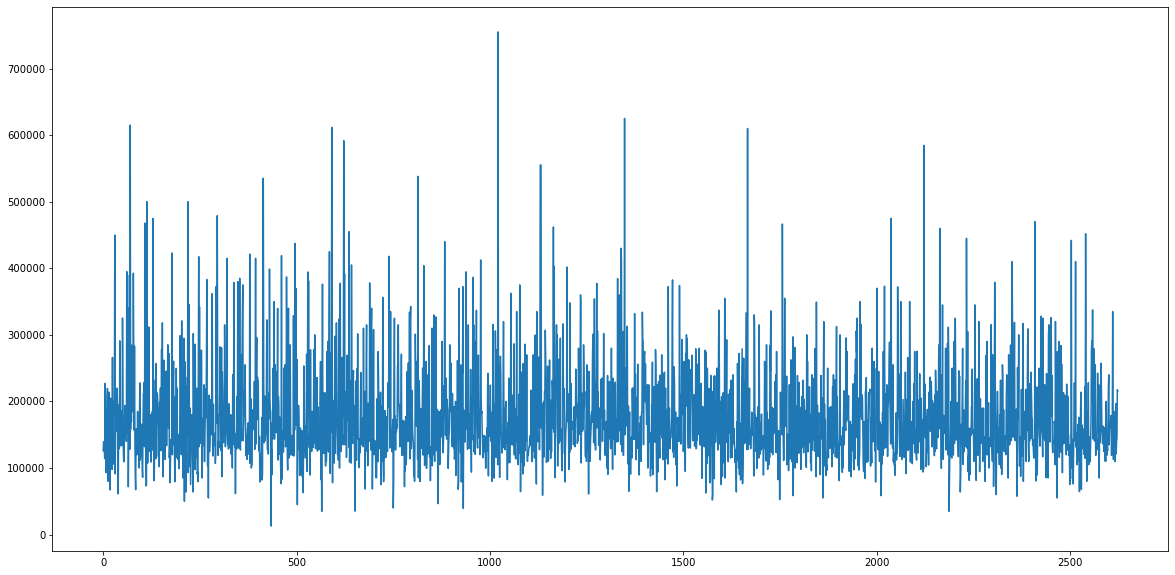

In [325]:
predict.plot()

In [326]:
data.head()

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,856,30,RL,64.9,7890,Pave,None,Reg,Lvl,AllPub,...,166,0,None,None,None,0,3,2010,WD,Normal
1,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal
2,1049,120,RL,42.0,4235,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,2,2009,WD,Normal
3,1001,30,C (all),60.0,6060,Pave,None,Reg,Lvl,AllPub,...,0,0,None,None,None,0,11,2007,WD,Normal
4,1039,70,RL,80.0,8146,Pave,None,Reg,Lvl,AllPub,...,111,0,None,None,None,0,5,2009,WD,Normal
